# Dask DataFrame

The dask dataframe coordinates multiple pandas dataframes in parallel to execute the defined computation.

Dask arranges these pandas dataframes along a row index and can execute computation on dataframes in-memory or on disk.

This notebook includes an analysis of crime data retreived from the [City of Vancouver data Catalogue](https://data.vancouver.ca/datacatalogue/crime-data.htm). The data was downloaded as a single csv file and has been split into multiple files for the purpose of this demo.

In [1]:
%matplotlib inline
import pathlib
import datetime
import dask.dataframe as df
import matplotlib.pyplot as plt

DATA_PATH = pathlib.Path('../data/crime/')

/home/bradleyk/.local/share/virtualenvs/dask-0UVi270T/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Below we can see the files on disk. There is a total of 16 csv files each containing the incidents report per year.

In [2]:
!ls ../data/crime/ -l --block-size=M | head -n 5

total 50M
-rw-r--r-- 1 bradleyk bradleyk 5M Jul 27 19:16 crime_2003.csv
-rw-r--r-- 1 bradleyk bradleyk 5M Jul 27 19:16 crime_2004.csv
-rw-r--r-- 1 bradleyk bradleyk 4M Jul 27 19:16 crime_2005.csv
-rw-r--r-- 1 bradleyk bradleyk 4M Jul 27 19:16 crime_2006.csv


Dask dataframe implements a subset of the pandas dataframe API. Given this, reading data is a simple task which should be familiar to any pandas user. Something to take note of in example below is that dask will read all 16 of the files once we call compute.

In [3]:
crime_data = df.read_csv('../data/crime/crime_*.csv')
crime_data

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
npartitions=16,,,,,,,,,,
,object,int64,int64,int64,float64,float64,object,object,float64,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


Similarly to pandas we can preview the first few rows and investigate the data types of the dataset using the `head` and `dtypes` commands.

In [4]:
crime_data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Theft from Vehicle,2003,10,6,9.0,0.0,4XX SE MARINE DR,Sunset,493059.11,5450912.60
1,Theft from Vehicle,2003,5,30,7.0,0.0,E HASTINGS ST / SALSBURY DR,Grandview-Woodland,495033.26,5458722.97
2,Theft from Vehicle,2003,2,2,16.0,45.0,E HASTINGS ST / SALSBURY DR,Grandview-Woodland,495033.26,5458722.97
3,Theft from Vehicle,2003,4,8,13.0,0.0,11XX W GEORGIA ST,West End,491034.25,5459231.00
4,Break and Enter Residential/Other,2003,12,15,13.0,0.0,10XX BURNABY ST,West End,490440.32,5458486.96


In [5]:
crime_data.dtypes

TYPE              object
YEAR               int64
MONTH              int64
DAY                int64
HOUR             float64
MINUTE           float64
HUNDRED_BLOCK     object
NEIGHBOURHOOD     object
X                float64
Y                float64
dtype: object

# Data Exploration

The next few examples will apply some basic aggregation to the dataset.

First up let's count the total number of incidents per year.

As with all dask collections, no computation takes place until the compute method is called.

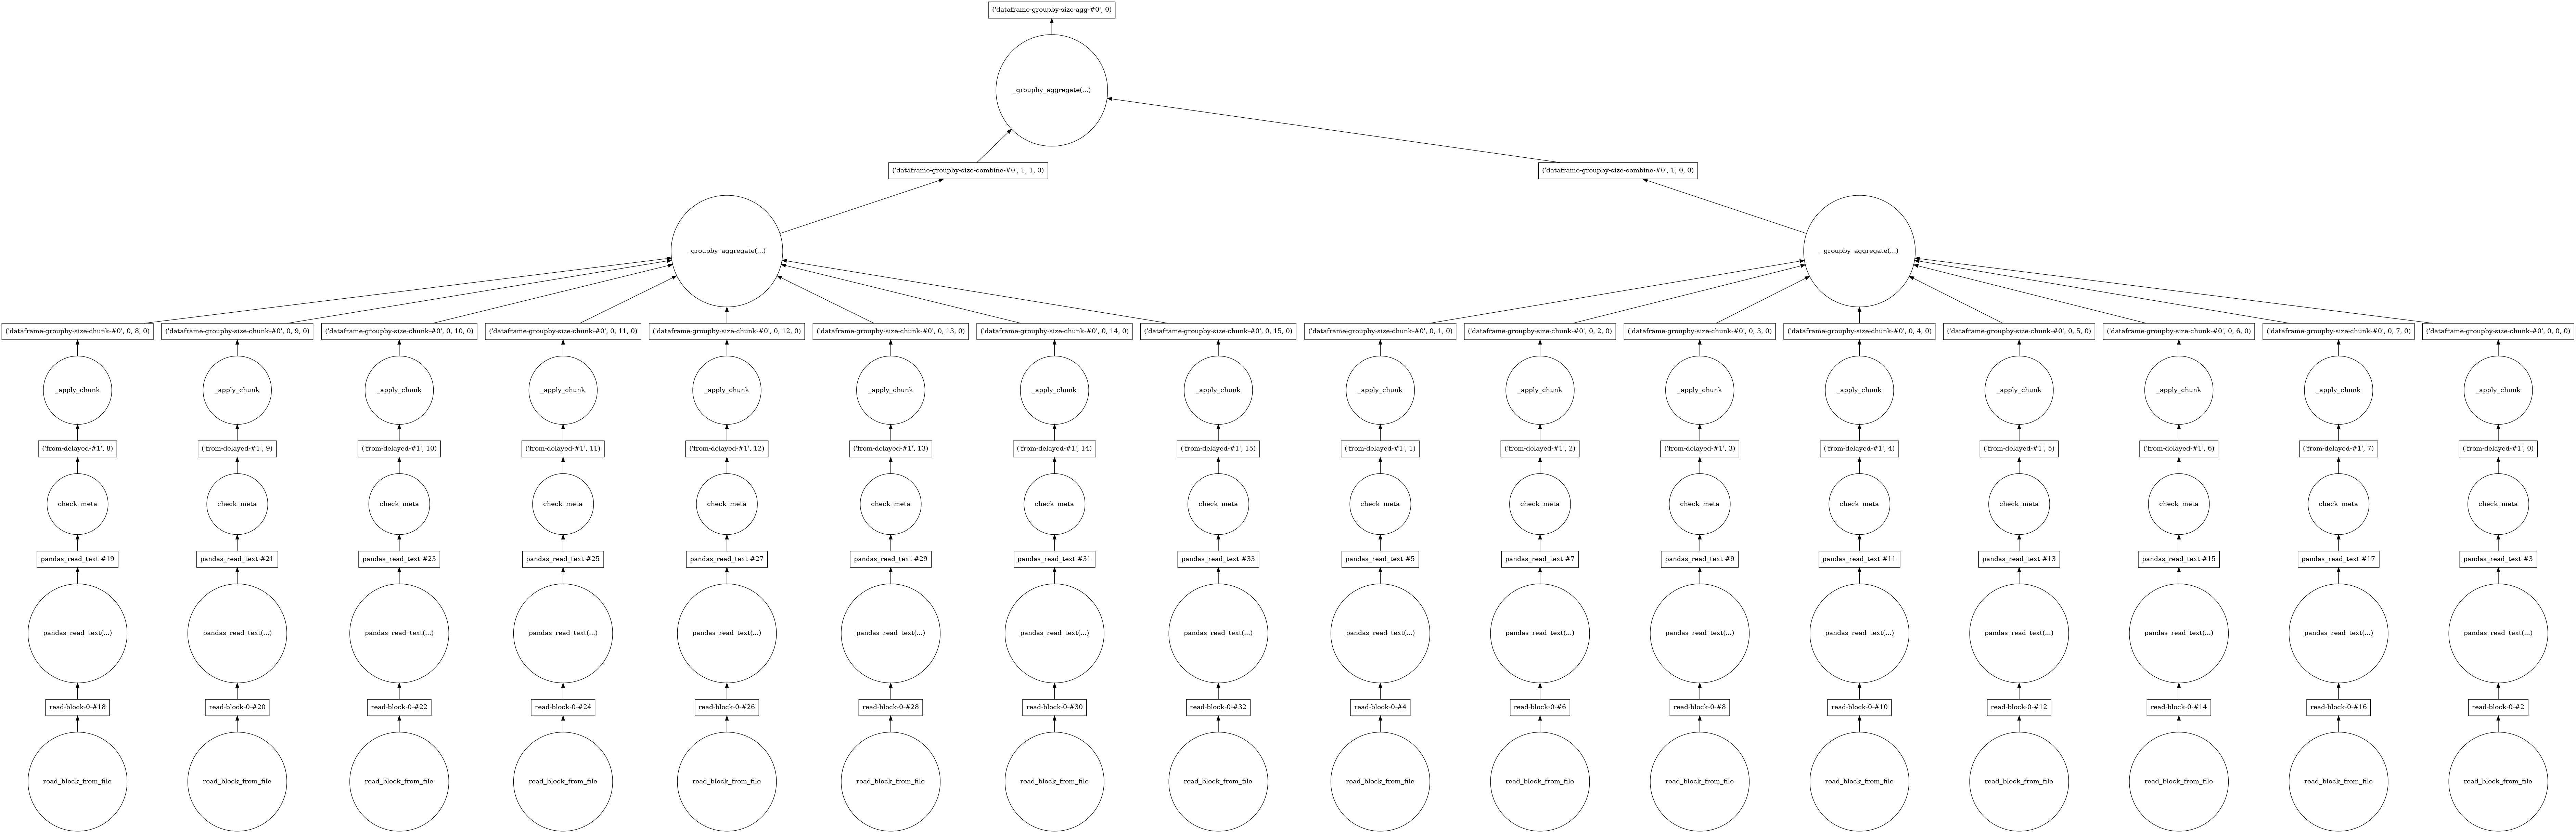

In [6]:
graph = (
    crime_data
        .groupby('YEAR')
        .size()
)

graph.visualize()

When we call compute below dask executes the task graph above until it arrives at the final result.

In [7]:
incidents_by_year = graph.compute()
incidents_by_year

YEAR
2003    49928
2004    49271
2005    44672
2006    42319
2007    37677
2008    35402
2009    32164
2010    29694
2011    28595
2012    29236
2013    29064
2014    32654
2015    34344
2016    37847
2017    36950
2018    20150
dtype: int64

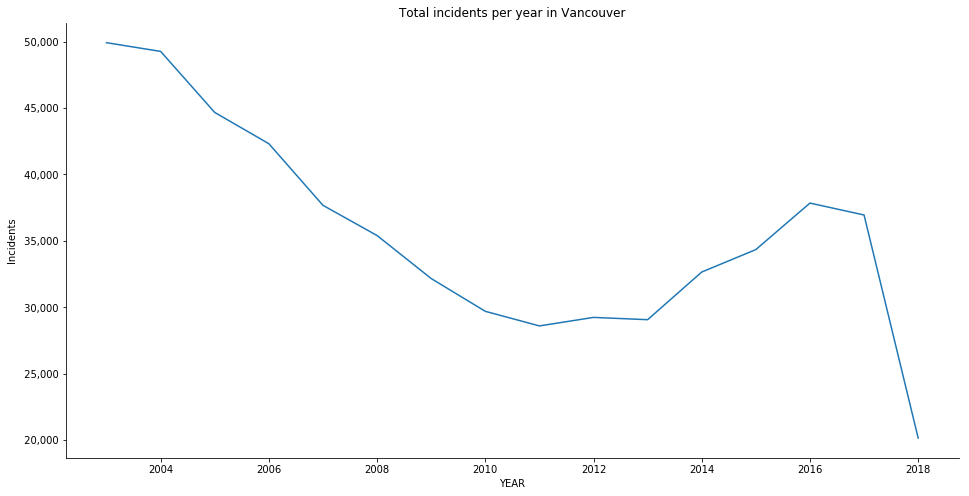

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))

incidents_by_year.plot(ax=ax)

ax.set_title('Total incidents per year in Vancouver')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, y: f"{x: ,.0f}"))
ax.set_ylabel('Incidents')
plt.show()

Next let's look at the total incidents per year for the 5 most typical incidents.

In [9]:
graph = (
    crime_data
        .groupby(['YEAR', 'TYPE'])
        .size()
        
)

incidents_by_year_and_type = graph.compute()
largest_types = (
    incidents_by_year_and_type
        .sum(level=1)
        .nlargest(5)
        .index
        .values
)

incidents_by_year_and_type = incidents_by_year_and_type.unstack()[largest_types]
incidents_by_year_and_type

TYPE,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Other Theft,Offence Against a Person
YEAR,,,,,
2003,17744,6391,6883,2582,3507
2004,18204,5601,6538,2605,3796
2005,16554,5062,5542,2611,3779
2006,14734,5184,5674,2966,4347
2007,12226,4810,4996,3024,4397
2008,11298,5276,4432,3142,4214
2009,10007,4430,3497,3662,3877
2010,8612,4506,3270,3432,3735
2011,7435,4828,3231,3562,3892


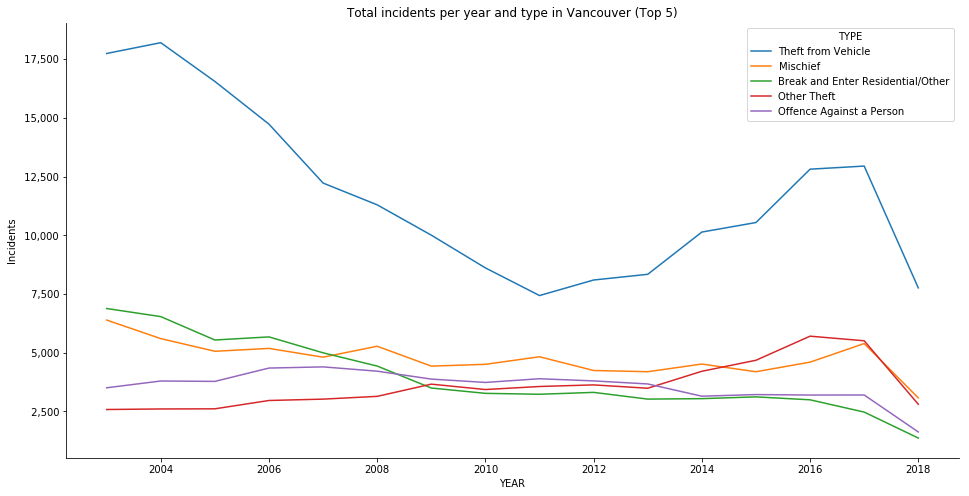

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

incidents_by_year_and_type.plot(ax=ax)

ax.set_title('Total incidents per year and type in Vancouver (Top 5)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, y: f"{x: ,.0f}"))
ax.set_ylabel('Incidents')
plt.show()

Finally, let's see at what times the mischief happens.

In [18]:
mischief_by_hour = (
    crime_data
        .loc[crime_data.TYPE == 'Mischief']
        .groupby('HOUR')
        .size()
        .compute()
)

/home/bradleyk/.local/share/virtualenvs/dask-0UVi270T/lib/python3.6/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


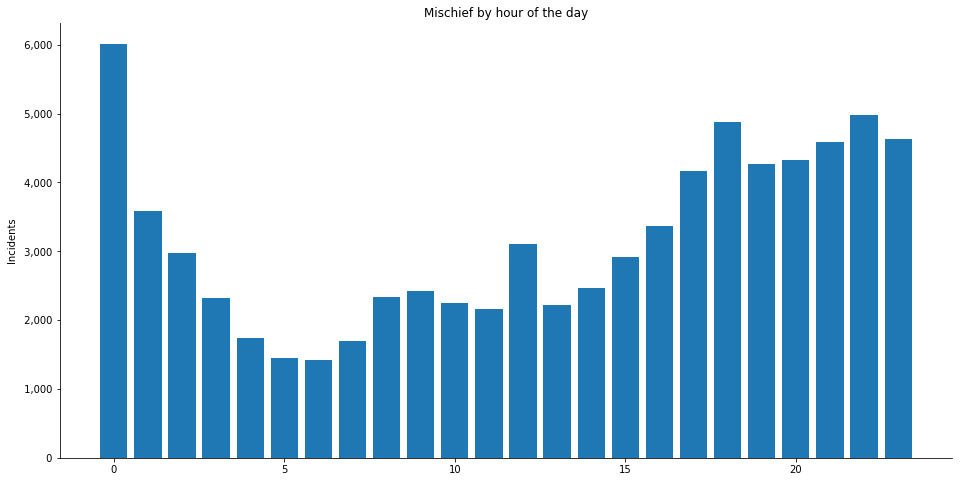

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(mischief_by_hour.index, mischief_by_hour.values)

ax.set_title('Mischief by hour of the day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, y: f"{x: ,.0f}"))
ax.set_ylabel('Incidents')
plt.show()